## Классификация MNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [2]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

Давайте обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В этом задании мы воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплайн обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку с первого занятия.

Мы настоятельно рекомендуем писать код «с нуля», лишь изредка подглядывая в готовые примеры, а не просто «копировать-вставлять». Это поможет вам в будущем.

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Text(0.5, 1.0, 'Image label: 3')

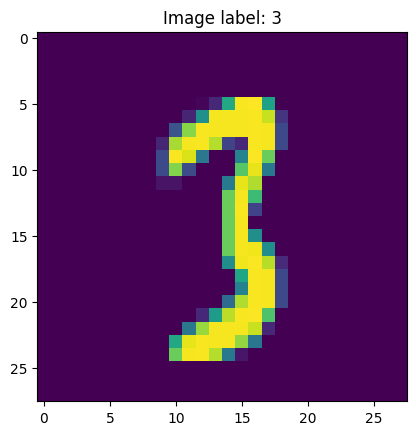

In [4]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,# Creating model instance
model = None # your code here
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель, представленную ниже. Пожалуйста, не создавайте чрезмерно сложную сеть — она не должна быть глубже четырёх слоёв (можно и меньше). Ваша основная задача — обучить модель и добиться как минимум 92% точности на тестовой выборке (hold-out выборке).

*Примечание: линейных слоёв и функций активации должно быть достаточно.*

__Обратите внимание, ваша модель должна быть представлена переменной `model`__

In [21]:
#device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = 'cpu'
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            #nn.Linear(512, 512),
            #nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


Ниже доступны локальные тесты для проверки вашей модели:

In [22]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)    
except Exception as e:
    print('Something is wrong with the model')
    raise e
    
    
assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Обучите модель на обучающей выборке. Рекомендуем поэкспериментировать с различными оптимизаторами.


In [34]:
# your code here

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_data_loader, model, loss_fn, optimizer)
    test(test_data_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


loss: 0.577219  [   32/60000]
loss: 0.247707  [ 3232/60000]
loss: 0.511131  [ 6432/60000]
loss: 0.360351  [ 9632/60000]
loss: 0.501241  [12832/60000]
loss: 0.295582  [16032/60000]
loss: 0.336279  [19232/60000]
loss: 0.572435  [22432/60000]
loss: 0.425005  [25632/60000]
loss: 0.134186  [28832/60000]
loss: 0.423668  [32032/60000]
loss: 0.549270  [35232/60000]
loss: 0.215406  [38432/60000]
loss: 0.250068  [41632/60000]
loss: 0.293251  [44832/60000]
loss: 0.789753  [48032/60000]
loss: 0.243933  [51232/60000]
loss: 0.290468  [54432/60000]
loss: 0.269816  [57632/60000]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.383692 

Epoch 2
-------------------------------
loss: 0.299556  [   32/60000]
loss: 0.561950  [ 3232/60000]
loss: 0.300867  [ 6432/60000]
loss: 0.355931  [ 9632/60000]
loss: 0.475037  [12832/60000]
loss: 0.589831  [16032/60000]
loss: 0.194602  [19232/60000]
loss: 0.334131  [22432/60000]
loss: 0.325352  [25632/60000]
loss: 0.364168  [28832/60000]
loss: 0.542586  [32032/60000]
loss: 0.

Также помните, что вы всегда можете обратиться к отличной [документации](https://pytorch.org/docs/stable/index.html) и [учебным материалам](https://pytorch.org/tutorials/).

Оценим качество классификации:

In [35]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [36]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.91637


In [37]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [38]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.92


Проверка, что пороги пройдены:

In [39]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model`, а файл `hw_mnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [41]:
# do not change the code in the block below
# __________start of block__________
import os
import json
assert os.path.exists('hw_mnist_data_dict.npy'), 'Please, download `hw_mnist_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):
    
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))
    
    predicted_labels = torch.cat(predicted_labels).numpy()
    predicted_labels = ','.join([str(x) for x in list(predicted_labels)])
    return predicted_labels

loaded_data_dict = np.load('hw_mnist_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test']))
}

with open('submission_dict_mnist_task_1.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict_mnist_task_1.json`')
# __________end of block__________

File saved to `submission_dict_mnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_mnist_task_1.json` в задачу Warmup (hw_mnist)

На этом задание завершено. Поздравляем!